In [1]:
# DNSGA
import time
from pymoo.algorithms.moo.dnsga2 import DNSGA2
from pymoo.core.callback import CallbackCollection, Callback
from pymoo.optimize import minimize
from pymoo.problems.dyn import TimeSimulation
from pymoo.problems.dynamic.df import DF1
import matplotlib.pyplot as plt
from pymoo.indicators.igd import IGD
from pymoo.indicators.hv import Hypervolume
from kgb import KGB
from statistics import mean
from pymoo.problems import get_problem
from pymoo.termination import get_termination
import json

# Experimental Settings
n_var = 5  # CEC 2018 requires 10 variables, 5 for showcasing purposes
change_frequency = 10  # 10 (fast changing env), 30 (slow changing env)
change_severity = 1 # severity of change 1 (high), 3 (medium), 5 (low)
pop_size = 100
max_n_gen = 30 * change_frequency  # CEC 2018: 30 * change_frequency
termination = get_termination("n_gen", max_n_gen)
problem_string = "df1"
verbose = False
seed = 1

In [2]:
# Metric Vars
po_gen = []
igds = []
hvs = []
pof = []
pos = []

def reset_metrics():
    global po_gen, igds, hvs, igds_monitor, hvs_monitor, pof, pos
    po_gen = []
    igds = []
    hvs = []
    igds_monitor = []
    hvs_monitor = []
    pof = []
    pos = []

def update_metrics(algorithm):

    _F = algorithm.opt.get("F")  # get function values of current best pop
    PF = algorithm.problem._calc_pareto_front()  # calculate current Pareto-Front
    igd = IGD(PF).do(_F)  # calculate igd
    hv = Hypervolume(pf=PF).do(_F)  # calculate hypervolume
    
    # Every Generation, get POS (optimal Population), igds, gds and hv
    pos.append(algorithm.opt.get("X"))
    igds.append(igd)
    hvs.append(hv)

    po_gen.append(algorithm.opt)
    
    # Every Generation, get updated true POF
    pof.append(PF)

class DefaultDynCallback(Callback):

    def _update(self, algorithm):

        update_metrics(algorithm)

        if algorithm.n_gen % 20 == 0:
            F = algorithm.opt.get("F")
            pf = algorithm.problem.pareto_front()

            plt.clf()
            plt.scatter(F[:, 0], F[:, 1])
            if pf is not None:
                plt.plot(pf[:, 0], pf[:, 1], color="black", alpha=0.7)

            plt.show()

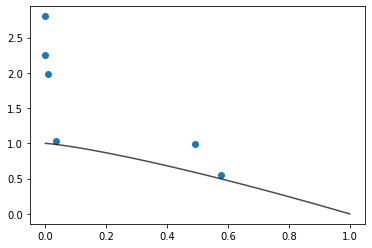

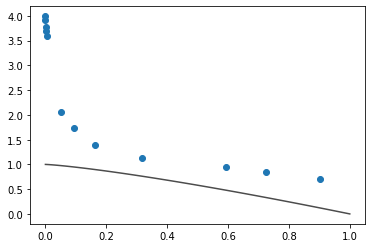

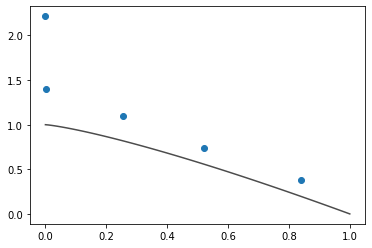

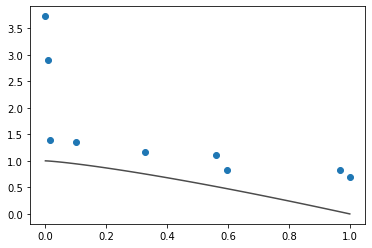

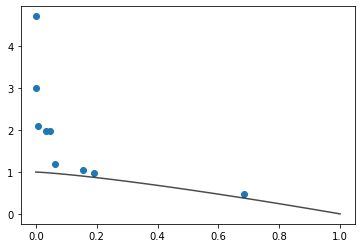

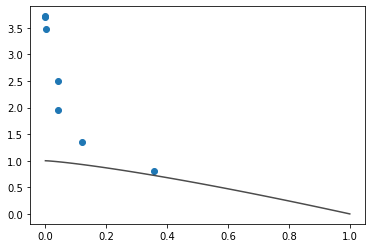

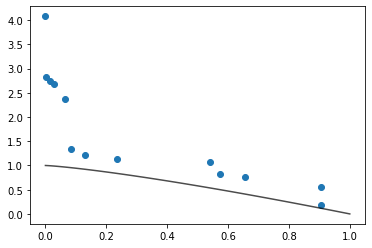

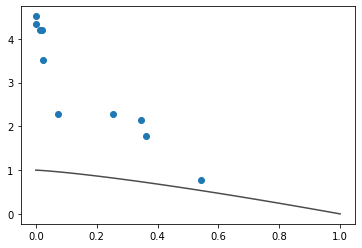

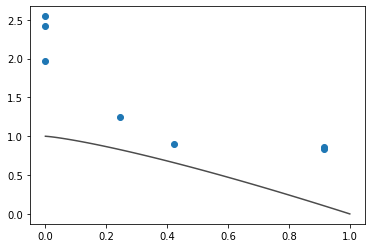

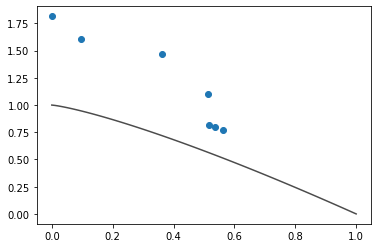

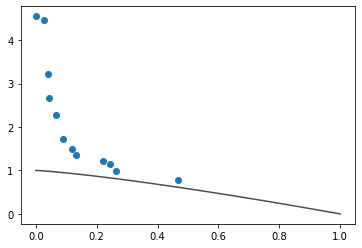

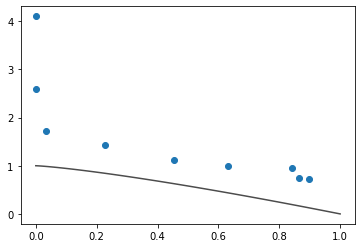

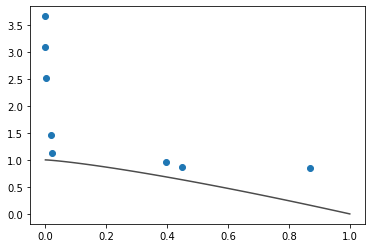

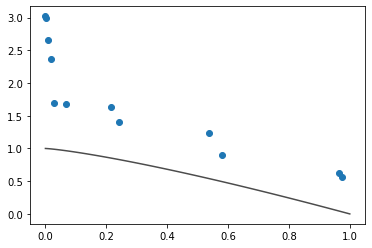

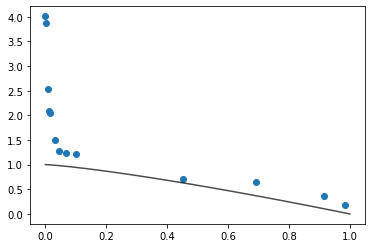

DNSGA2 Performance
Time: 5.569918870925903
MIGDS 0.13842689494031948
MHV 0.29757439267233915


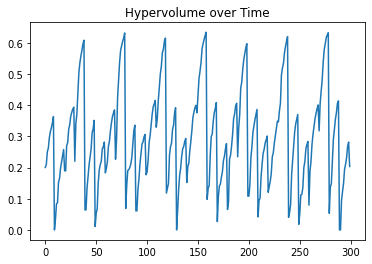

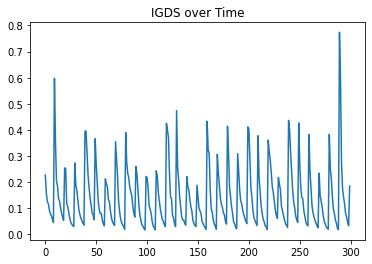

In [3]:
# DNSGA2

problem = get_problem(problem_string, taut=change_frequency, nt = change_severity, n_var=n_var)
algorithm = DNSGA2(pop_size=pop_size)
simulation = TimeSimulation()

start = time.time()
res = minimize(problem,
               algorithm,
               termination=termination,
               callback=CallbackCollection(DefaultDynCallback(), simulation),
               seed=seed,
               verbose=verbose)

print("DNSGA2 Performance")
print(f'Time: {time.time() - start}')
print("MIGDS", mean(igds))
print("MHV", mean(hvs))

plt.title("Hypervolume over Time")
plt.plot(hvs)
plt.show()
plt.title("IGDS over Time")
plt.plot(igds)
plt.show()
reset_metrics()

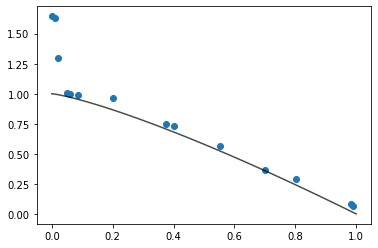

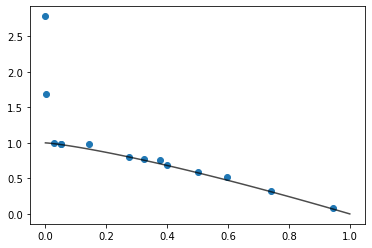

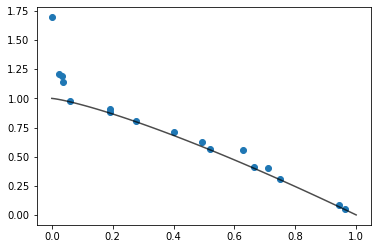

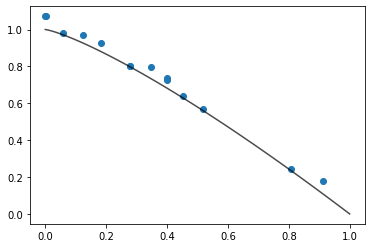

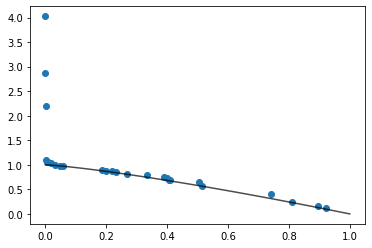

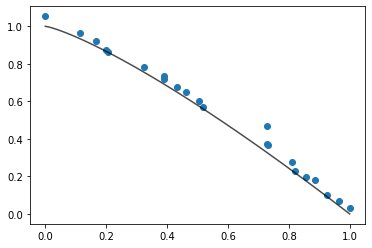

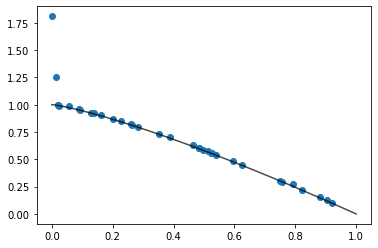

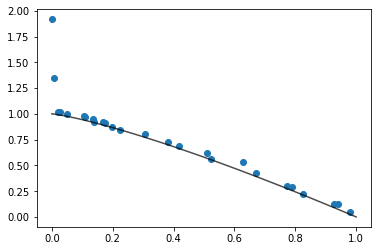

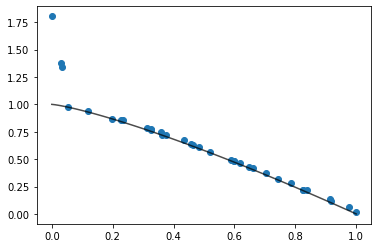

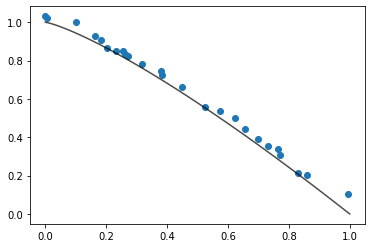

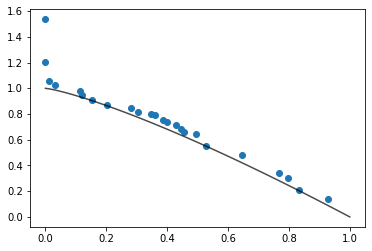

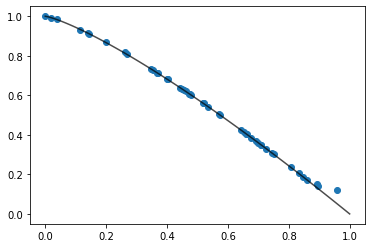

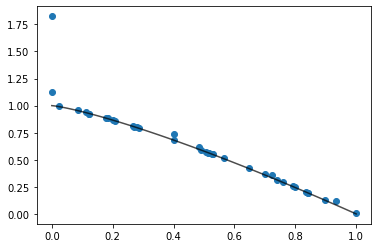

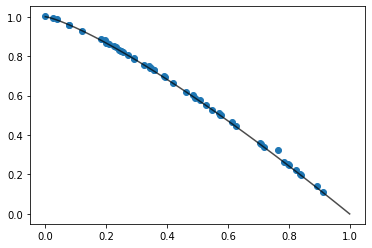

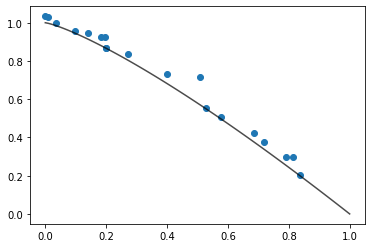

KGBDMOEA Performance
Time: 92.61087679862976
MIGDS 0.022668594000845345
MHV 0.43298414087762765


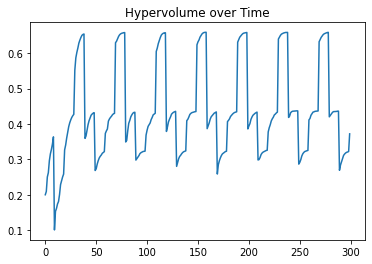

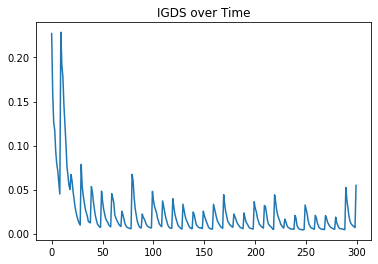

In [4]:
# KGB-DMOEA

problem = get_problem(problem_string, taut=change_frequency, nt = change_severity, n_var=n_var)
algorithm = KGB(pop_size=pop_size, save_ps=True)
simulation = TimeSimulation()

start = time.time()
res = minimize(problem,
               algorithm,
               termination=termination,
               callback=CallbackCollection(DefaultDynCallback(), simulation),
               seed=seed,
               verbose=verbose)

print("KGBDMOEA Performance")
print(f'Time: {time.time() - start}')
print("MIGDS", mean(igds))
print("MHV", mean(hvs))

plt.title("Hypervolume over Time")
plt.plot(hvs)
plt.show()
plt.title("IGDS over Time")
plt.plot(igds)
plt.show()
reset_metrics()

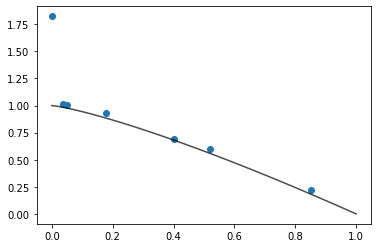

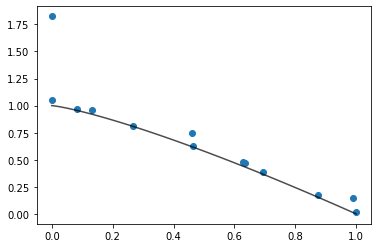

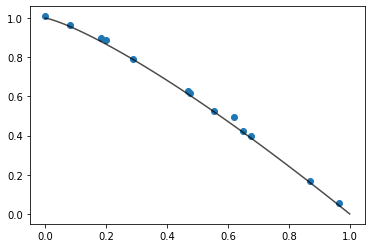

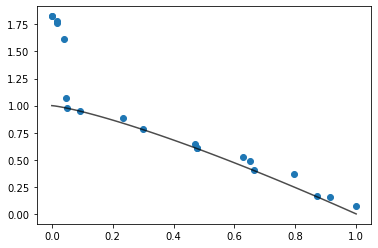

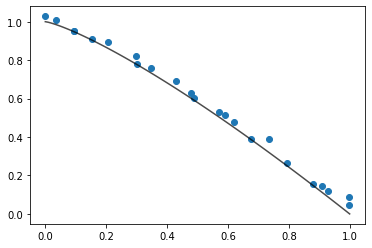

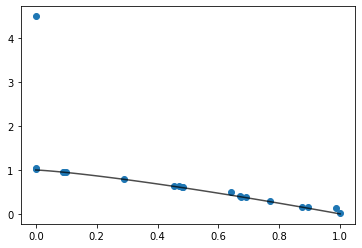

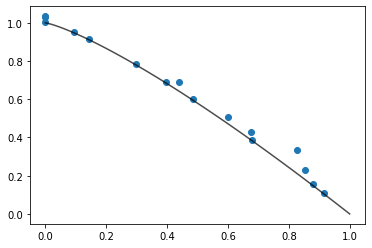

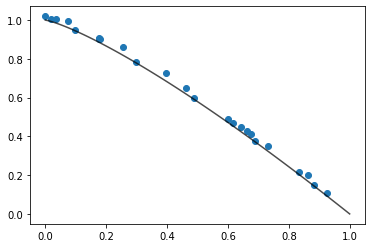

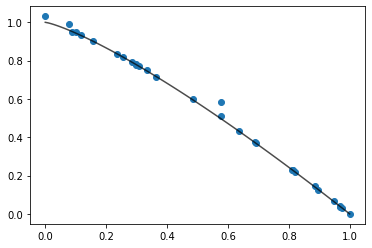

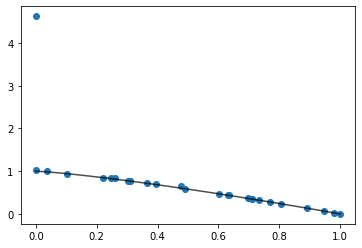

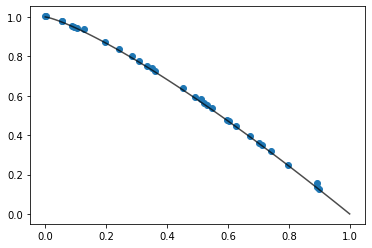

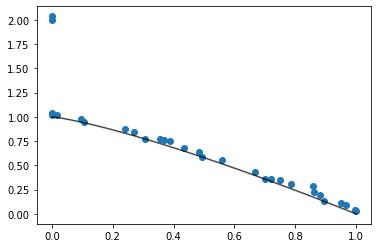

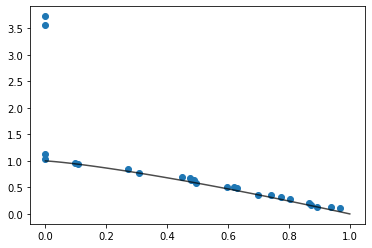

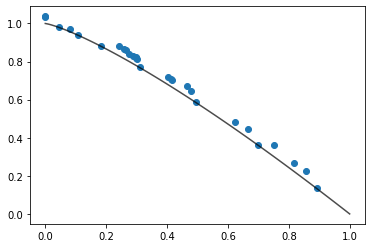

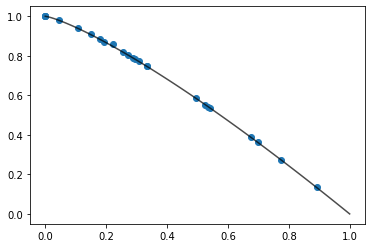

KGBDMOEA Performance
Time: 94.56849551200867
MIGDS 0.019213922614551352
MHV 0.4375509916184436


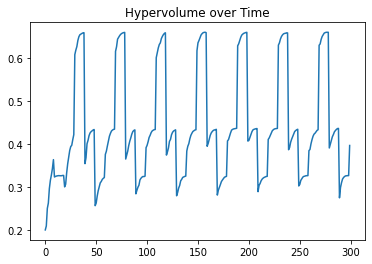

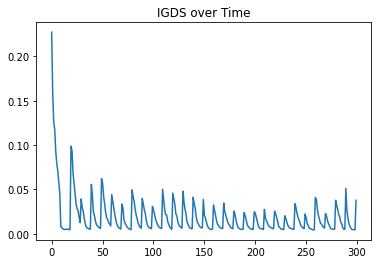

In [5]:
# KGB-DMOA with PS Init

# load archive of POS
with open('ps.json', 'r') as f:
    ps = json.load(f)

# KGB-DMOEA
problem = get_problem(problem_string, taut=change_frequency, nt = change_severity, n_var=n_var)
algorithm = KGB(pop_size=pop_size, ps=ps, save_ps=True)
simulation = TimeSimulation()

start = time.time()
res = minimize(problem,
               algorithm,
               termination=termination,
               callback=CallbackCollection(DefaultDynCallback(), simulation),
               seed=seed,
               verbose=verbose)

print("KGBDMOEA Performance")
print(f'Time: {time.time() - start}')
print("MIGDS", mean(igds))
print("MHV", mean(hvs))

plt.title("Hypervolume over Time")
plt.plot(hvs)
plt.show()
plt.title("IGDS over Time")
plt.plot(igds)
plt.show()
reset_metrics()